# Compare anomalies between GIMMS-PKU consolidate, Landsat, and AVHRR-Adj.


In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Open datasets

In [3]:
# cdr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_'+model_var+'_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
# cdr = assign_crs(cdr, crs=crs)
# cdr.attrs['nodata'] = np.nan
# cdr = cdr.rename('NDVI')

syn = xr.open_dataset(f'{base}/synthetic/{model_var}/{model_var}_CLIM_synthetic_5km_monthly_1982_2022.nc')['NDVI']
syn = assign_crs(syn, crs=crs)
syn.attrs['nodata'] = np.nan
syn = syn.rename({model_var})

pku = xr.open_dataarray(f'{base}/{model_var}_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

ls = xr.open_dataset(base+'/NDVI_harmonization/Landsat_NDVI_5km_monthly_1988_2012.nc')['NDVI']
ls = assign_crs(ls, crs=crs)
ls.attrs['nodata'] = np.nan

# merge = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_NOCLIM_LGBM_5km_monthly_1982_2022_wGaps.nc')['NDVI']
merge = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc')['NDVI']
merge = assign_crs(merge, crs=crs)
merge.attrs['nodata'] = np.nan
merge = merge.rename('NDVI')

rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain = assign_crs(rain, crs=crs)
rain.attrs['nodata'] = np.nan

## Match datasets

In [4]:
merge = merge.odc.reproject(pku.odc.geobox, resampling='average')
ls = ls.odc.reproject(pku.odc.geobox, resampling='average')
rain = rain.odc.reproject(pku.odc.geobox, resampling='average')
syn = syn.odc.reproject(pku.odc.geobox, resampling='average')

merge = round_coords(merge)
ls = round_coords(ls)
pku = round_coords(pku)
rain = round_coords(rain)
syn = round_coords(syn)

In [5]:
avhrr_mask =  ~np.isnan(merge)
del avhrr_mask.attrs['nodata']
avhrr_mask = assign_crs(avhrr_mask, crs=crs)

# cdr_mask =  ~np.isnan(cdr)
# del cdr_mask.attrs['nodata']
# cdr_mask = assign_crs(cdr_mask, crs=crs)

pku_mask =  ~np.isnan(pku)
del pku_mask.attrs['nodata']
pku_mask = assign_crs(pku_mask, crs=crs)

ls_mask =  ~np.isnan(ls)
del ls_mask.attrs['nodata']
ls_mask = assign_crs(ls_mask, crs=crs)

#combine masks
mask = (avhrr_mask & pku_mask & ls_mask) # & cdr_mask

In [6]:
pku = pku.sel(time=ls.time).where(mask)
merge = merge.sel(time=ls.time).where(mask)
rain = rain.sel(time=ls.time).where(mask)
syn = syn.sel(time=ls.time).where(mask)
ls = ls.where(mask)

merge = merge.rename({'latitude':'y', 'longitude':'x'})
pku = pku.rename({'latitude':'y', 'longitude':'x'})
ls = ls.rename({'latitude':'y', 'longitude':'x'})
rain = rain.rename({'latitude':'y', 'longitude':'x'})
syn = syn.rename({'latitude':'y', 'longitude':'x'})

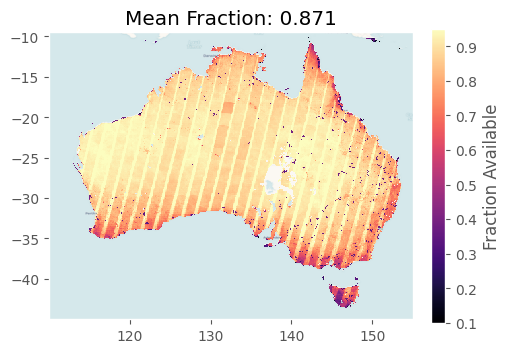

In [7]:
fraction_avail= (~np.isnan(pku)).sum('time')/len(pku.time)

fig,ax=plt.subplots(1,1, figsize=(5,4),sharey=True, layout='constrained')

im = fraction_avail.where(fraction_avail>0).rename('').plot(vmin=0.1, vmax=0.95, ax=ax, cmap='magma', add_labels=False, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

cb = fig.colorbar(im, ax=ax, shrink=0.75, orientation='vertical', label='Fraction Available');
ax.set_title('Mean Fraction: '+str(round(fraction_avail.where(fraction_avail>0).mean().values.item(), 3)));

## Calculate standardised anomalies

In [8]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def stand_anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.groupby("time.month").mean(),
            ds.groupby("time.month").std()
    )
    
rain_std_anom = stand_anomalies(rain)
pku_std_anom = stand_anomalies(pku)
merge_std_anom = stand_anomalies(merge)
ls_std_anom = stand_anomalies(ls)
syn_std_anom = stand_anomalies(syn)

## Rolling mean anomalies

In [19]:
roll=12

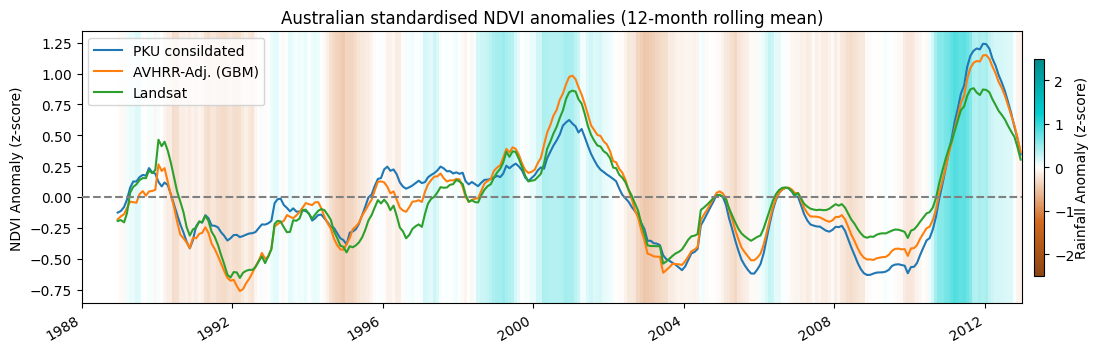

In [20]:
rain_df = rain_std_anom.rename('rain').rolling(time=roll,
                min_periods=roll).mean().mean(['x','y']).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax2 = ax.twinx()

pku_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='PKU consildated')
# syn_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='Synthetic')
merge_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='AVHRR-Adj. (GBM)')
ls_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='Landsat')

norm=plt.Normalize(-2.5,2.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)
ax.axhline(0, c='grey', linestyle='--')

# Reformat y-axis label and tick labels
ax.set_ylabel(model_var+' Anomaly (z-score)')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.margins(x=0)
ax2.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend()
ax.set_title('Australian standardised NDVI anomalies ('+str(roll)+'-month rolling mean)');
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Australian_NDVI_compare_PKU_landsat_"+str(roll)+"Mrollingmean.png",
            bbox_inches='tight', dpi=300)

### Compare rainfall anomalies with NDVI anomalies per pixel

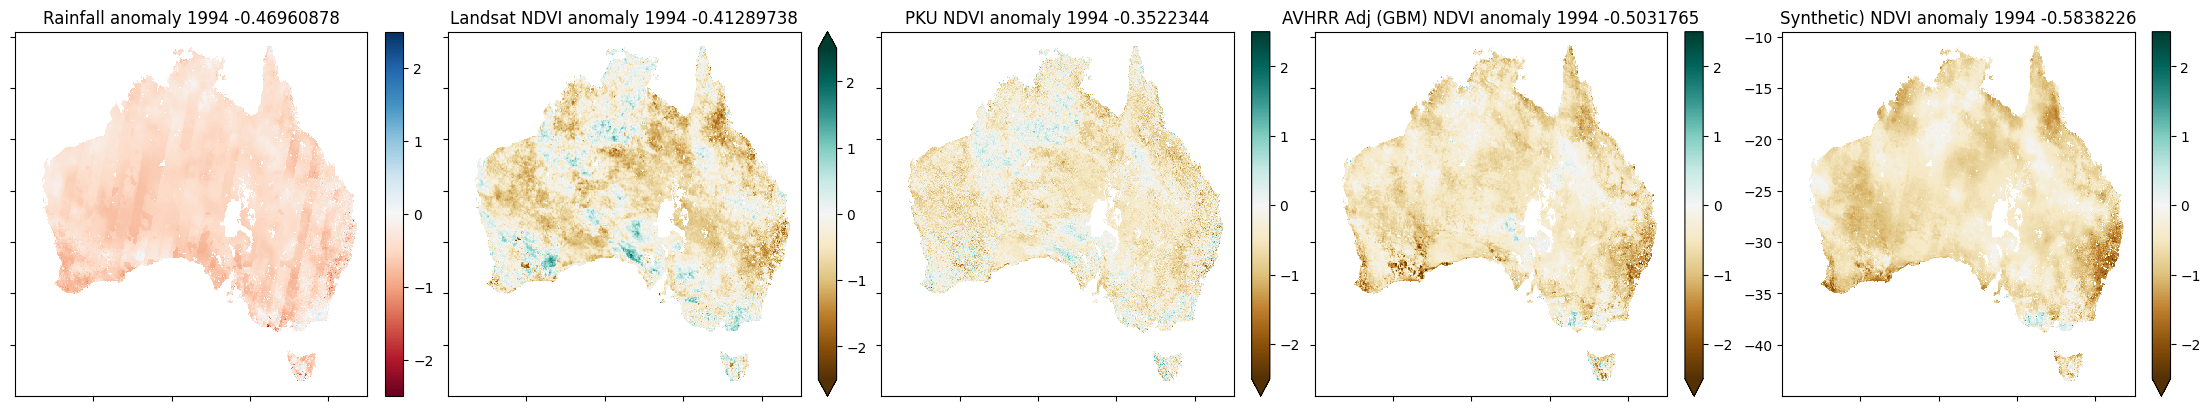

In [11]:
year='1994'

fig,ax = plt.subplots(1,5, figsize=(22,4), sharex=True, layout='constrained')
rain_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='RdBu', ax=ax[0], add_labels=False)
ls_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[1], add_labels=False)
pku_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[2], add_labels=False)
merge_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[3], add_labels=False)
syn_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[4], add_labels=False)

ax[0].set_title('Rainfall anomaly '+year+' '+str(rain_std_anom.sel(time=year).mean().values))
ax[1].set_title('Landsat NDVI anomaly '+year+' '+str(ls_std_anom.sel(time=year).mean().values))
ax[2].set_title('PKU NDVI anomaly '+year+' '+str(pku_std_anom.sel(time=year).mean().values))
ax[3].set_title('AVHRR Adj (GBM) NDVI anomaly '+year+' '+str(merge_std_anom.sel(time=year).mean().values))
ax[4].set_title('Synthetic) NDVI anomaly '+year+' '+str(syn_std_anom.sel(time=year).mean().values))

ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([]);

ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_xticklabels([]);

ax[2].set_yticklabels([])
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_xticklabels([]);

ax[3].set_yticklabels([])
ax[3].set_ylabel('')
ax[3].set_xlabel('')
ax[3].set_xticklabels([]);

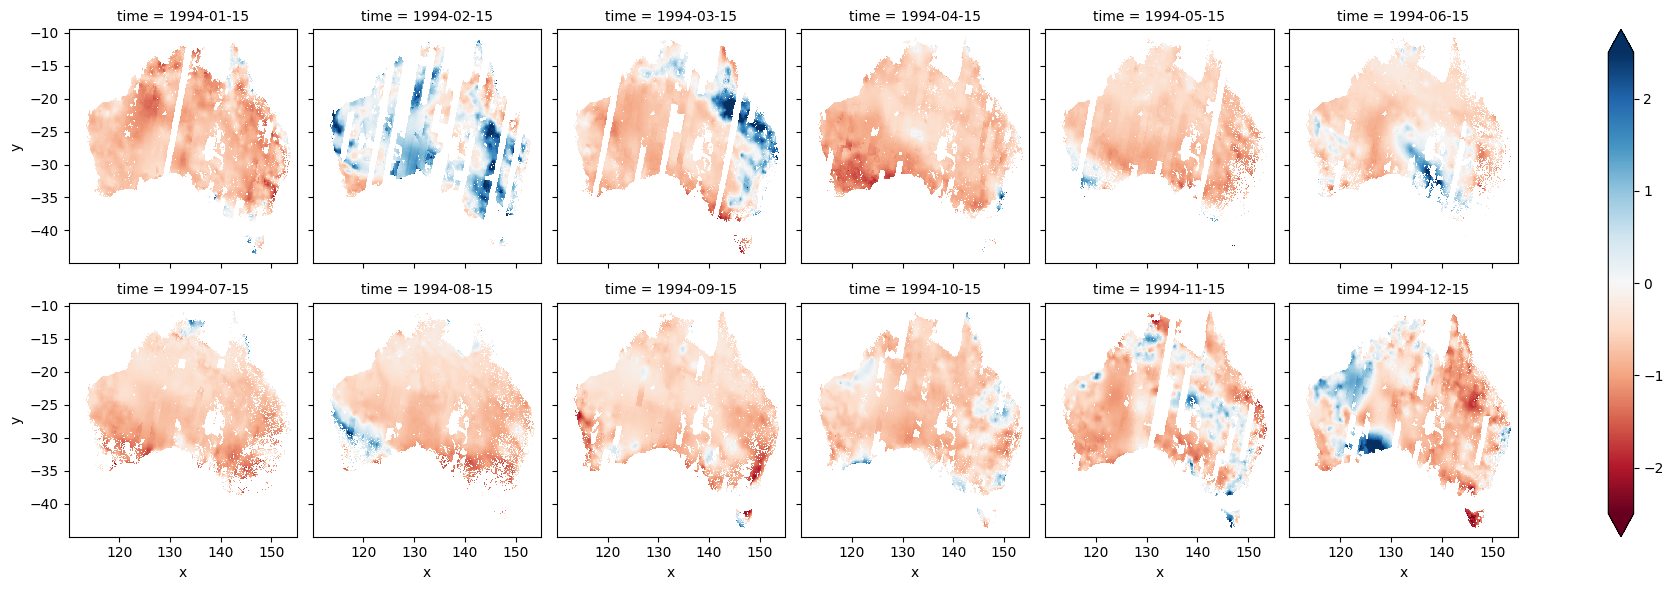

In [12]:
rain_std_anom.sel(time=year).plot.imshow(vmin=-2.5, vmax=2.5, cmap='RdBu', col='time', col_wrap=6);

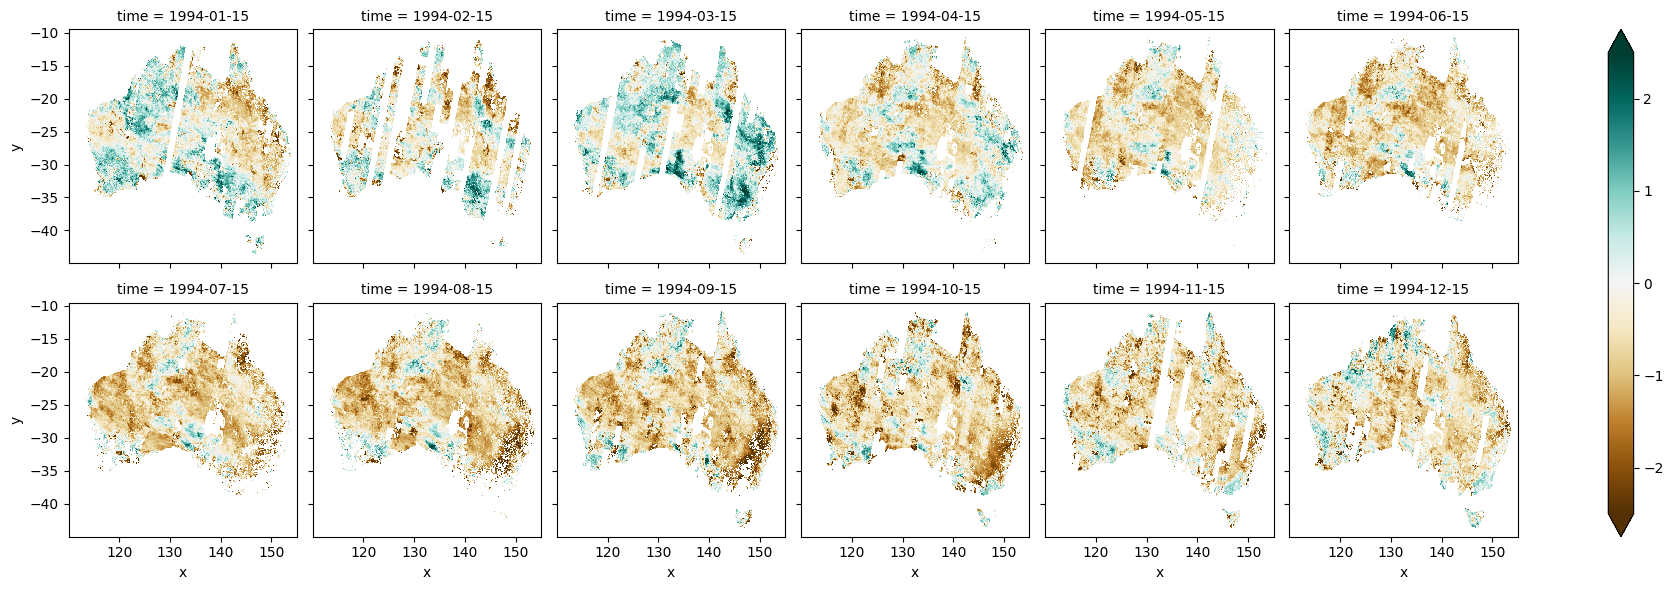

In [13]:
ls_std_anom.sel(time=year).plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', col='time', col_wrap=6);

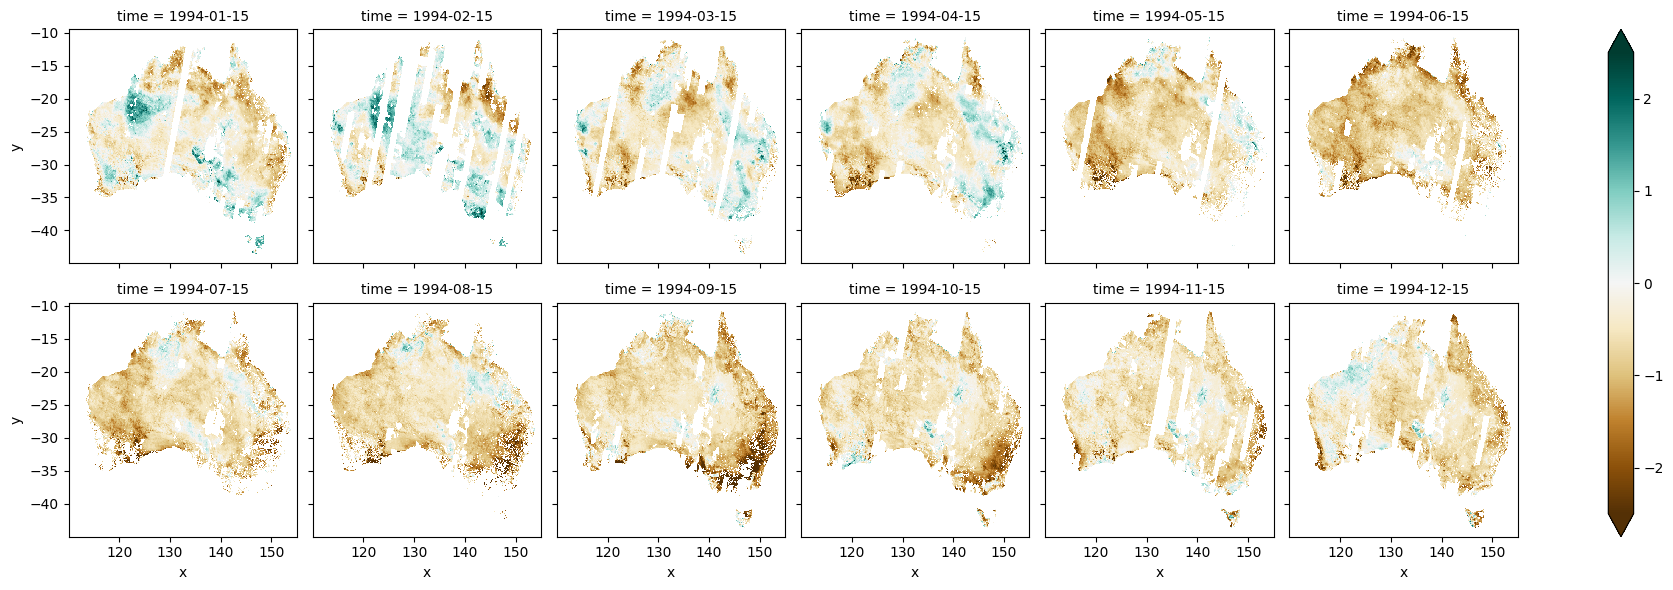

In [14]:
merge_std_anom.sel(time=year).plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', col='time', col_wrap=6);

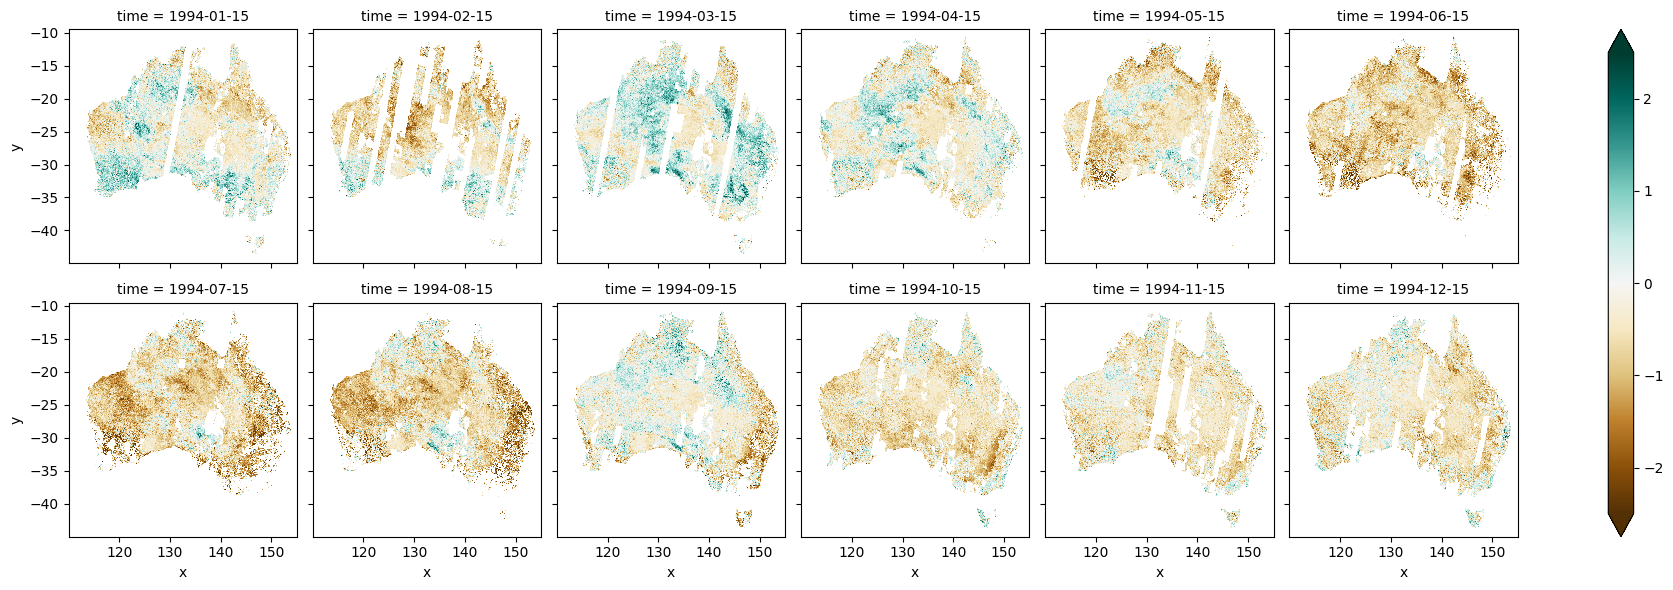

In [15]:
pku_std_anom.sel(time=year).plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', col='time', col_wrap=6);

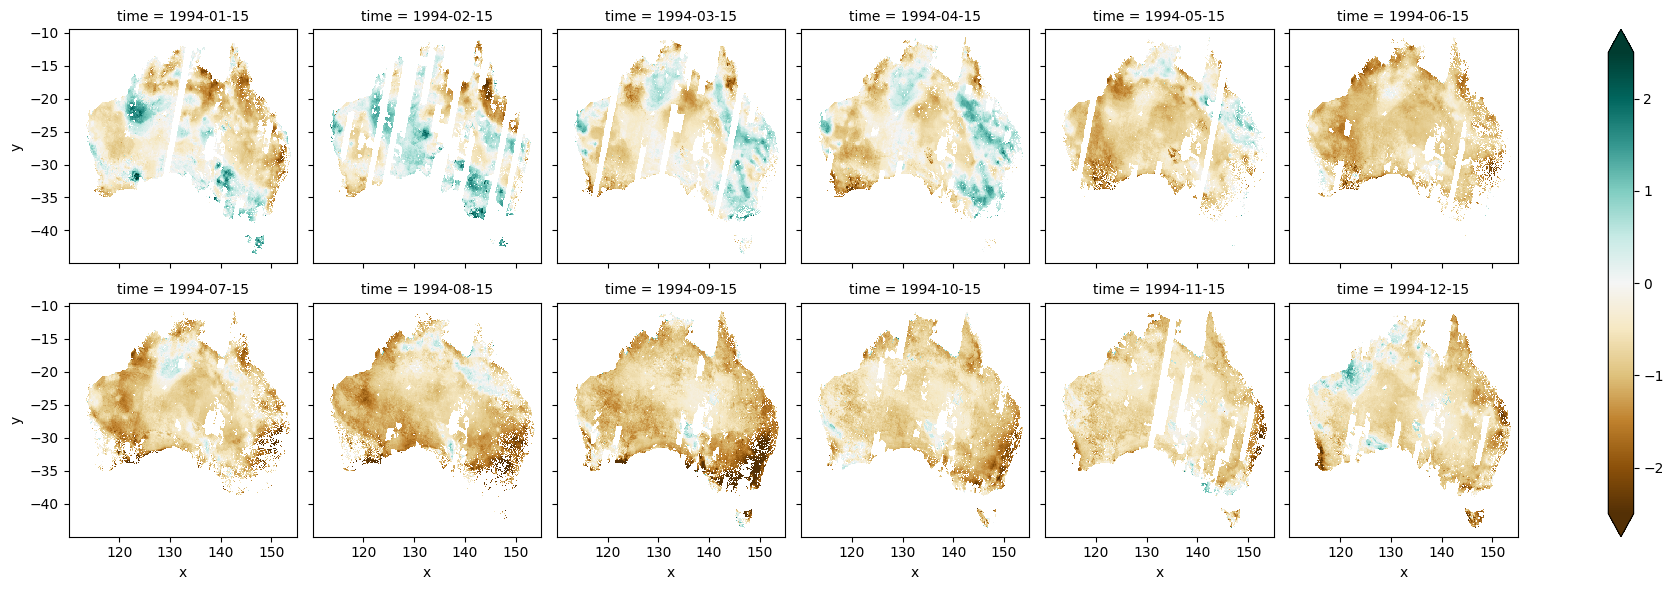

In [16]:
syn_std_anom.sel(time=year).plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', col='time', col_wrap=6);

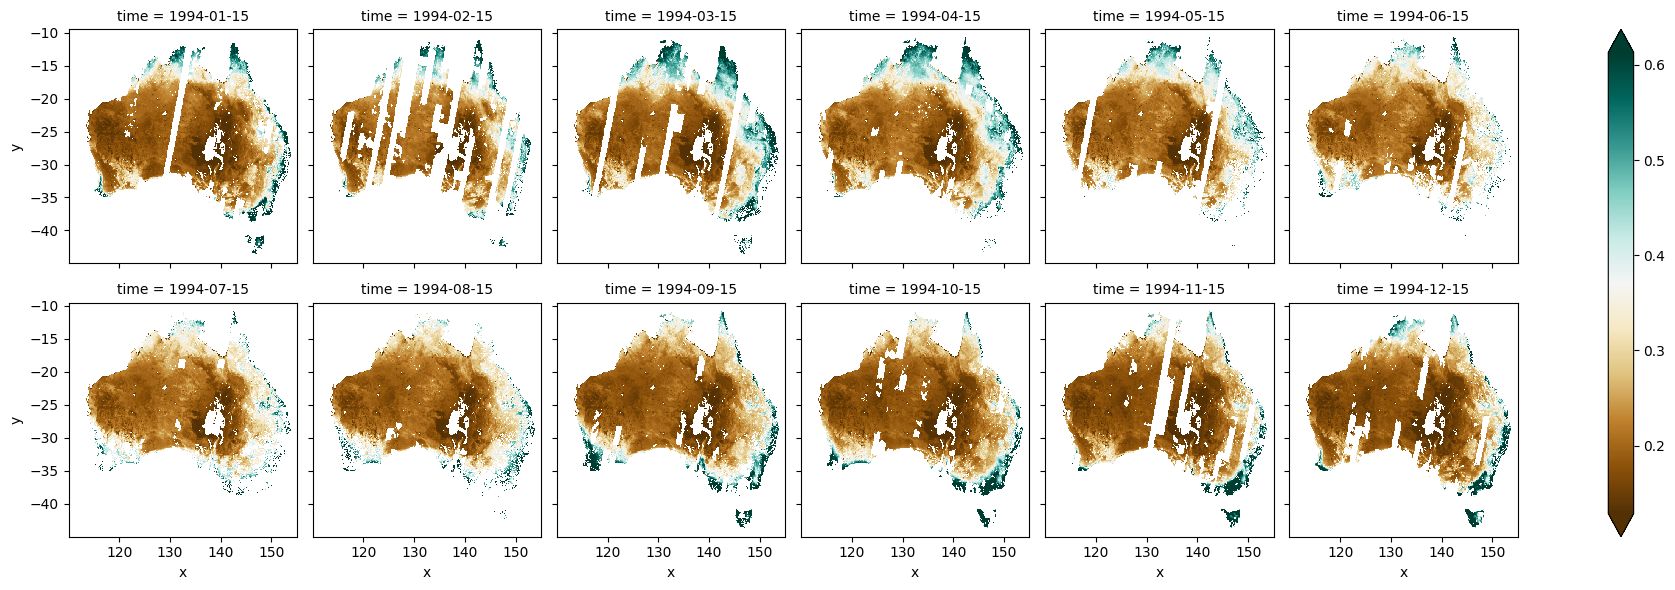

In [17]:
syn.sel(time=year).plot.imshow(robust=True, cmap='BrBG', col='time', col_wrap=6);

In [18]:
(merge.sel(time=year)-syn.sel(time=year)).min()#.plot.imshow(robust=True, cmap='BrBG', col='time', col_wrap=6);

<xarray.DataArray ()>
array(0.)
Coordinates:
    spatial_ref  int32 4326